In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

#from abm_utils import empirical_prevalence, simulate_abm, create_obs_infer
from utils_local.misc import amro2title, amro2cute


In [3]:
gammas_search = [0.25, 0.5] #, 0.75]
betas_search  = [0.01, 0.05, 0.1]
rho_search    = [1/100, 5/100, 10/100, 18/100]

idx_sce            = 0
scenarios_large_df = pd.DataFrame(columns=["scenario", "gamma", "beta", "rho"])
for g in gammas_search:
    for b in betas_search:
        for r in rho_search:
            scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
            idx_sce += 1


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_75870/2300007364.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_75870/2300007364.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_75870/2300007364.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"

In [4]:
#from models import amr_abm, observe_cluster_individual

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "k"                 : 6
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0


In [5]:
from diagnostic_plots import convergence_plot
from utils import create_df_response

id_run       = 0
posterior_df = pd.DataFrame()

for idx_row, row in scenarios_large_df.iterrows():
    path_to_samples = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"], "infer_building", f"scenario{idx_row+1}")
    inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

    θmle      = inference["mle"]
    θpost     = inference["posterior"]
    y_sim     = inference["observations"]
    θtruth    = inference["teta_truth"]
    idx_infer = inference["idx_infer"]
    Nif       = θpost.shape[-1]

    ρ_post = θpost[0, :, :, :].mean(-2).flatten()
    β_post = θpost[1, :, :, :].mean(-2).flatten()

    post_df                = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter"])
    post_df["value"]       = np.concatenate([ρ_post, β_post])
    post_df["value_truth"] = np.concatenate([θtruth[0, 0] * np.ones_like(ρ_post),
                                                θtruth[1, 0] * np.ones_like(β_post)])

    post_df["param"]    = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
    post_df["if_iter"]  = flatten_list([list(range(Nif)) * model_settings["m"] ] * 2 )
    post_df["ens_id"]   = flatten_list([[i] * Nif for i in range( model_settings["m"])] * 2)
    post_df["gamma"]    = row.gamma
    post_df["scenario"] = idx_row

    posterior_df        = pd.concat([posterior_df, post_df])

In [6]:
from utils_local import plot_utils
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

v_df = posterior_df[posterior_df["if_iter"] == Nif-1]


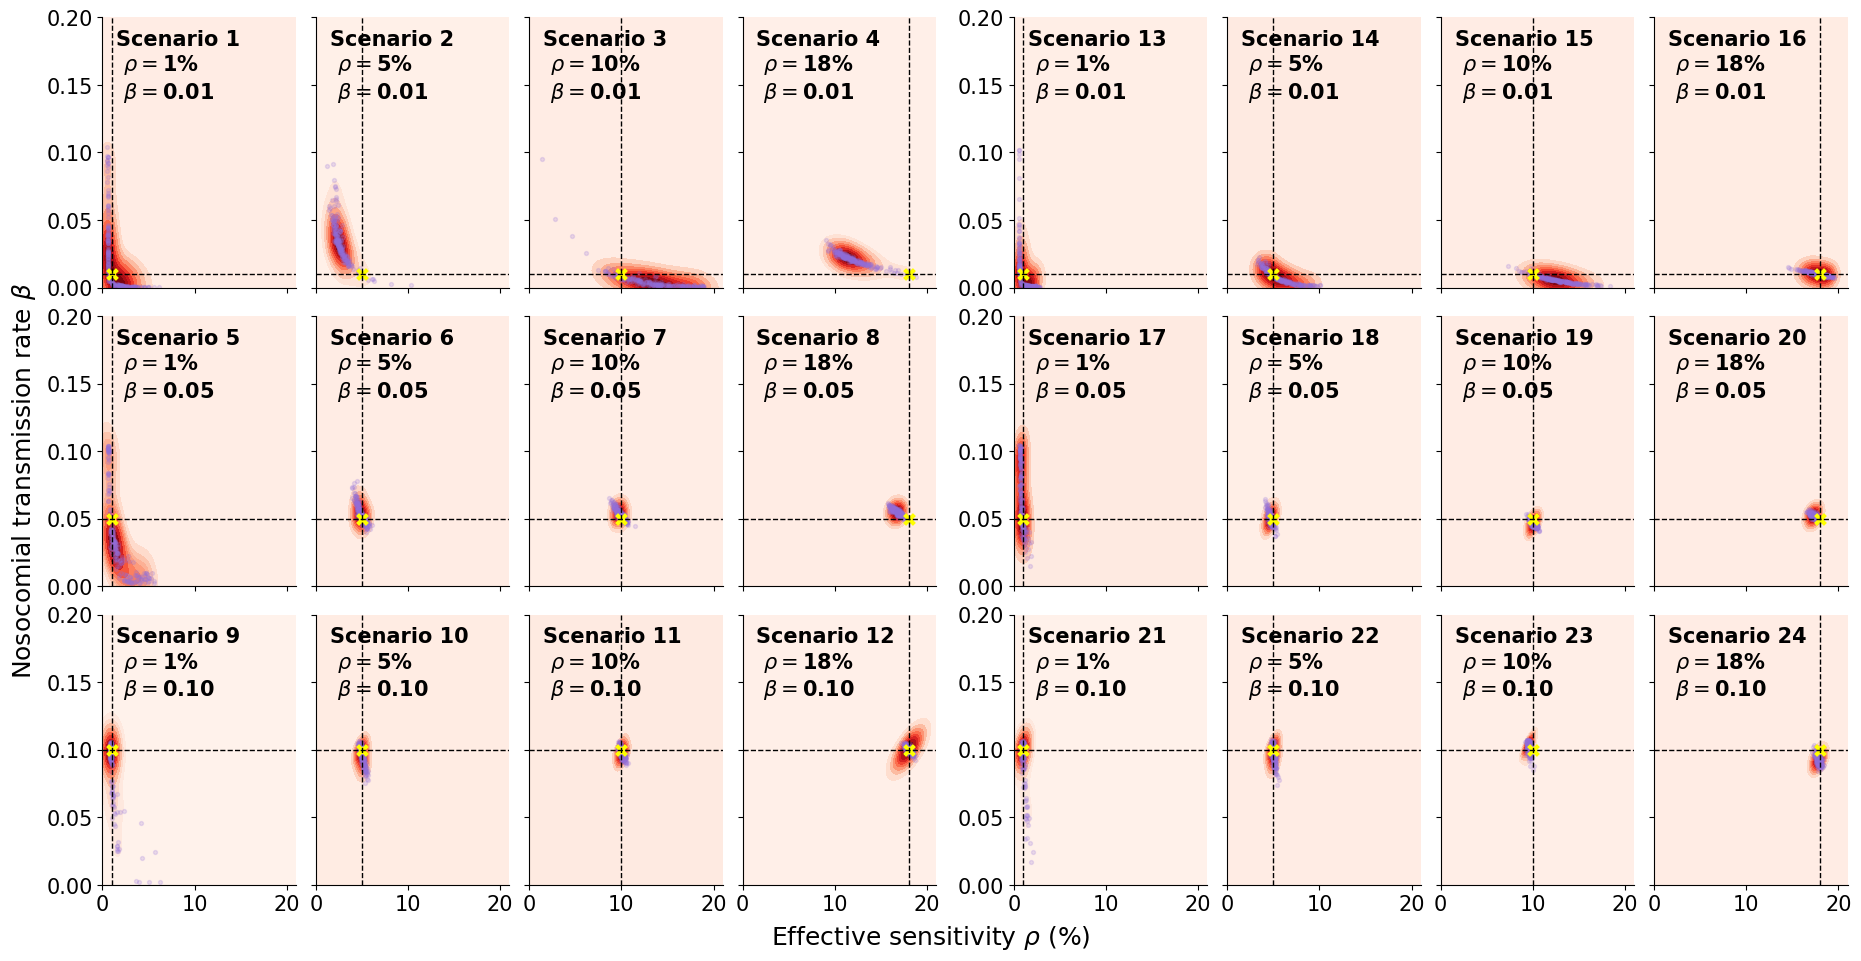

In [14]:
fig     = plt.figure(constrained_layout=True, figsize=(18.5, 9.5))
subfigs = fig.subfigures(1, 2, hspace=0.07, wspace=0.01, width_ratios=[0.5, 0.5])

######################## figure A, γ = 25% ######################################
axes1    = subfigs[0].subplots(3, 4, sharex=True, sharey=True)

for idx_scenario, ax in enumerate(axes1.flatten()):
    p_df             = v_df[v_df.gamma == 0.25]
    p_df             = p_df[p_df["scenario"] == p_df["scenario"].unique()[idx_scenario]]
    rho_df           = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
    beta_df          = p_df[p_df["param"] == "β"].reset_index(drop=True)
    rho_df["value"]  = rho_df["value"] * 100


    if p_df.scenario.unique()[0]+1==12:
        sns.kdeplot(ax         = ax,
                        x      = list(rho_df["value"].values) + [0, 20]      +[0, 20]      +[0, 20]      +[0, 20],
                        y      = list(beta_df["value"])       + [-0.02, 0.22]+[-0.02, 0.22]+[-0.02, 0.22]+[-0.02, 0.22],
                        cmap   = "Reds",
                        fill   = True,
                        thresh = 0)
    else:
        sns.kdeplot(ax     = ax,
                        x      = list(rho_df["value"].values) + [0, 20],
                        y      = list(beta_df["value"])       + [-0.02, 0.22],
                        cmap   = "Reds",
                        fill   = True,
                        thresh = 0)

    ax.scatter(x          = rho_df["value"],
                y         = beta_df["value"],
                facecolor = "mediumpurple",
                edgecolor = None, alpha=0.2, s=8)

    ax.axhline(y=beta_df["value_truth"].drop_duplicates().values[0], color="k", lw=1, ls="--")
    ax.axvline(x=rho_df["value_truth"].drop_duplicates().values[0] * 100, color="k", lw=1, ls="--")

    ax.scatter(x          = rho_df["value_truth"].drop_duplicates()*100,
                y         = beta_df["value_truth"].drop_duplicates(),
                marker    = "x",
                facecolor = "yellow",
                lw        = 3,
                s         = 50)

    ax.text(x = 1.5,
            y = 0.14,
            s = "Scenario {}\n".format(p_df.scenario.unique()[0]+1)+r" $\rho=${:0.0f}%".format(rho_df["value_truth"].drop_duplicates().values[0]*100,) +"\n"+
                    r" $\beta=${:0.2f}".format(beta_df["value_truth"].drop_duplicates().values[0]),
            weight='bold', color="k")

    ylim = ax.get_ylim()
    ax.set_ylim((0, 0.2))
    ax.set_xlim((0, 21))

    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

#for i in range(4):
#    axes1[-1, i].set_xlabel(r"$\rho$ (%)")
#
#for i in range(3):
#    axes1[i, 0].set_ylabel(r"$\beta$")
#
#################################################################################

######################## figure B, γ = 50% ######################################
axes2    = subfigs[1].subplots(3, 4, sharex=True, sharey=True)
for idx_scenario, ax in enumerate(axes2.flatten()):
    p_df             = v_df[v_df.gamma == 0.5]
    p_df             = p_df[p_df["scenario"] == p_df["scenario"].unique()[idx_scenario]]
    rho_df           = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
    beta_df          = p_df[p_df["param"] == "β"].reset_index(drop=True)
    rho_df["value"]  = rho_df["value"] * 100

    sns.kdeplot(ax         = ax,
                    x      = list(rho_df["value"].values) + [0, 20],
                    y      = list(beta_df["value"])       + [-0.02, 0.22],
                    cmap   = "Reds",
                    fill   = True,
                    thresh = 0)

    ax.scatter(x          = rho_df["value"],
                y         = beta_df["value"],
                facecolor = "mediumpurple",
                edgecolor = None, alpha=0.2, s=8)

    ax.axhline(y=beta_df["value_truth"].drop_duplicates().values[0],      c="k", lw=1, ls="--")
    ax.axvline(x=rho_df["value_truth"].drop_duplicates().values[0] * 100, c="k", lw=1, ls="--")

    ax.scatter(x          = rho_df["value_truth"].drop_duplicates()*100,
                y         = beta_df["value_truth"].drop_duplicates(),
                marker    = "x",
                facecolor = "yellow",
                lw        = 3,
                s         = 50)
    ax.text(x = 1.5,
            y = 0.14,
            s = "Scenario {}\n".format(p_df.scenario.unique()[0]+1)+r" $\rho=${:0.0f}%".format(rho_df["value_truth"].drop_duplicates().values[0]*100,) +"\n"+
                    r" $\beta=${:0.2f}".format(beta_df["value_truth"].drop_duplicates().values[0]),
            weight='bold', color="k")

    ylim = ax.get_ylim( )
    ax.set_ylim((0, 0.2))
    ax.set_xlim((0, 21))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

#################################################################################

fig.supxlabel(r'Effective sensitivity $\rho$ (%)')
fig.supylabel(r'Nosocomial transmission rate $\beta$')

#################################################################################

fig.savefig(os.path.join(results2_dir, "paper_figures", "fig2.png"),
                                            dpi=300, transparent=True)



In [8]:
# Supplementary figure 8

In [9]:
from eval.calibration import calibration
def create_sim_df(sim_samples, model_settings):
    """ Sample from the posterior simultion

    Args:
        sim_samples: Array with shape (k: num_observations, m: num_samples, T: length of simulation)
        model_settings: _description_
    """
    k, m , T = sim_samples.shape
    y = sim_samples

    sim_df = pd.DataFrame()
    for ki in range(model_settings["k"]):
        df           = pd.DataFrame(np.squeeze(y[ki, :, :]).flatten(), columns=["value"])
        df["date"]   = flatten_list([list(model_settings["dates_simulation"])] * model_settings["m"])
        df["ens_id"] = flatten_list([[mi]*model_settings["T"] for mi in range(model_settings["m"])])
        df           = df.set_index(["date", "ens_id"]).unstack([1]).resample("W-Sun").sum().stack().reset_index()
        df["yi"]     = ki
        sim_df       = pd.concat([sim_df, df])
    return sim_df

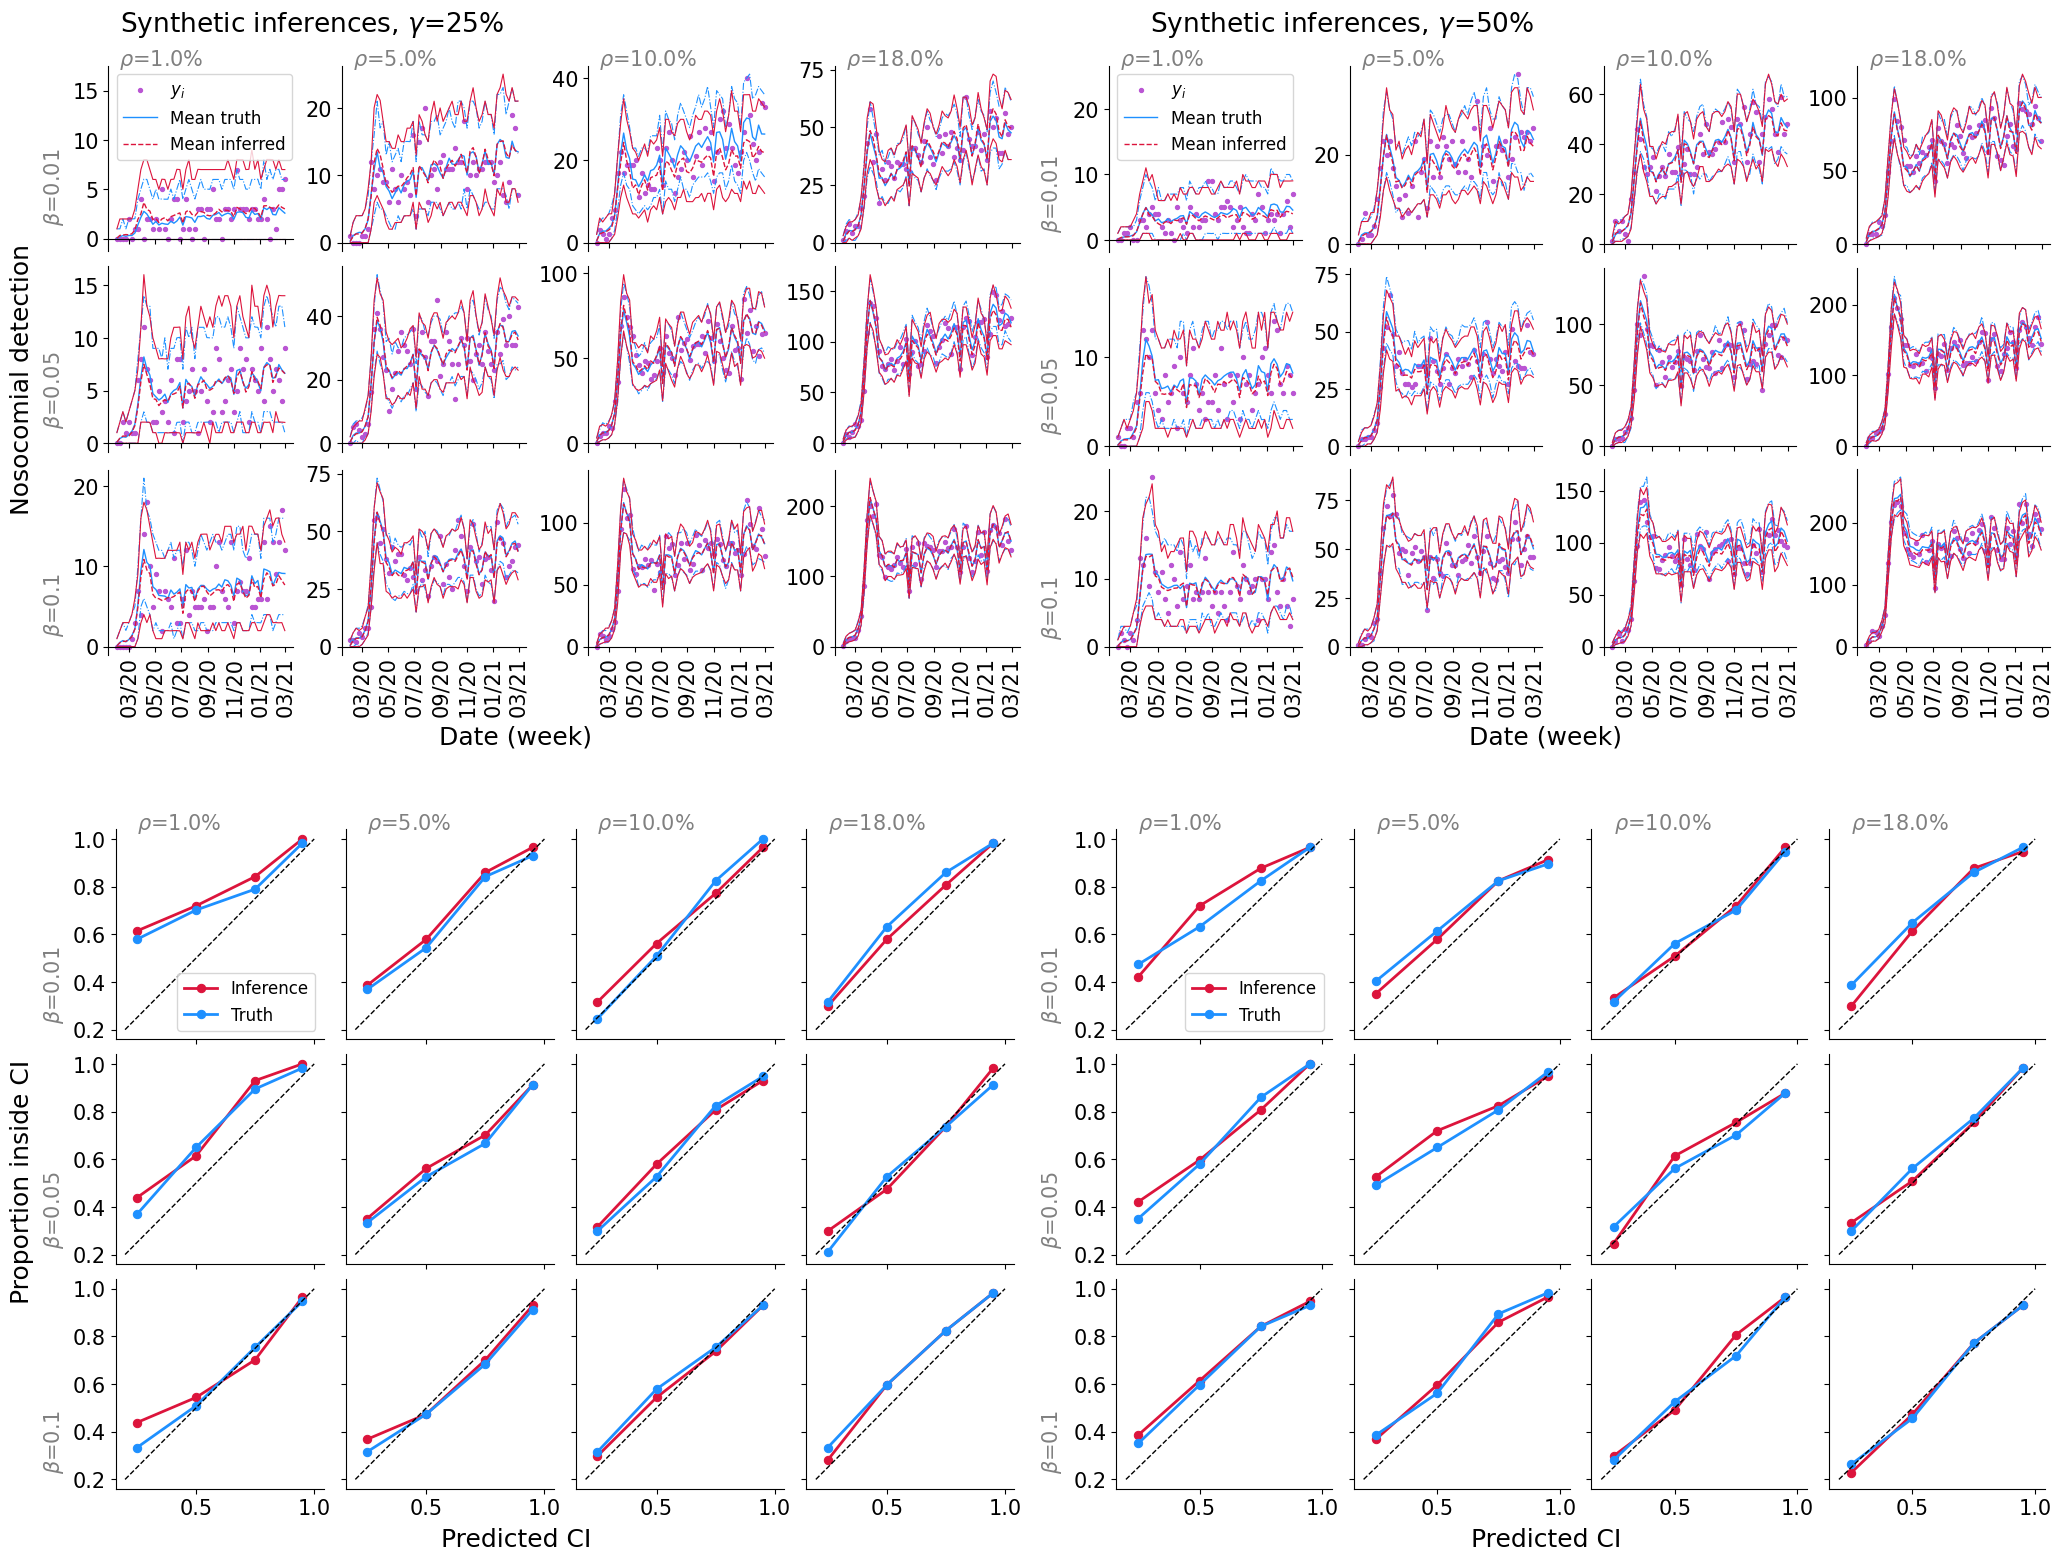

In [10]:
from matplotlib import dates as mdates
from utils import create_df_response
from utils_local import plot_utils
import matplotlib.pyplot as plt
import seaborn as sns

hosp_calibration_df = pd.DataFrame()

fig     = plt.figure(constrained_layout=True, figsize=(20.5, 15.5))
subfigs = fig.subfigures(2, 2, hspace=0.07, wspace=0.01, width_ratios=[0.5, 0.5])
idx_row, row = next(scenarios_large_df.iterrows())

axes_all = []
for idx_gamma, gamma in enumerate(gammas_search):

    #fig, axes = plt.subplots(3, 4, figsize=(12.5, 7.2), sharex=True, sharey=False)
    axes = subfigs[0, idx_gamma].subplots(3, 4, sharex=True, sharey=False)
    axes_all.append(axes)

    for id_ax, ax in enumerate(axes.flatten()):
        sce_g_df = scenarios_large_df[scenarios_large_df["gamma"]==gamma]
        scenario = sce_g_df.iloc[id_ax]["scenario"]

        path_to_save    = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", scenario)
        path_to_samples = os.path.join(path_to_save, "infer_building", scenario)

        post_sim     = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}sim_post.npz"))

        obs_infer_df         = pd.DataFrame(post_sim["y_data"], columns=[f"y{i+1}" for i in range(model_settings["k"])])# at hospital level
        obs_infer_df["date"] = model_settings["dates_simulation"]
        obs_infer_df         = obs_infer_df.set_index("date").resample("W-Sun").sum()
        obs_infer_df         = pd.DataFrame(obs_infer_df.sum(1)).rename(columns={0: "value"})

        obs_all_df  = create_sim_df(post_sim["y_dist"].transpose(1, 2, 0), model_settings).groupby(["date", "ens_id"]).sum()[["value"]].unstack([1]).resample("W-Sun").sum().stack().reset_index()
        sim_df      = create_sim_df(post_sim["y"].transpose(1, 2, 0), model_settings).groupby(["date", "ens_id"]).sum()[["value"]].unstack([1]).resample("W-Sun").sum().stack().reset_index()

        hosp_samples   = sim_df.pivot(index="date", columns="ens_id", values="value").to_numpy()
        obs_truth_dist = obs_all_df.pivot(index="date", columns="ens_id", values="value").to_numpy()

        hosp_sim_df   = create_df_response(np.squeeze(hosp_samples),   time = len(if_settings["assimilation_dates"]), dates = if_settings["assimilation_dates"])
        hosp_truth_df = create_df_response(np.squeeze(obs_truth_dist), time = len(if_settings["assimilation_dates"]), dates = if_settings["assimilation_dates"])

        c_infer_df                = calibration(np.expand_dims(hosp_samples, 0), obs_infer_df.values.T)
        c_infer_df["observation"] = "posterior"
        c_infer_df["gamma"]       = gamma
        c_infer_df["scenario"]    = scenario
        c_truth_df                = calibration(np.expand_dims(obs_truth_dist, 0), obs_infer_df.values.T)
        c_truth_df["observation"] = "truth"
        c_truth_df["gamma"]       = gamma
        c_truth_df["scenario"]    = scenario
        hosp_calibration_df       = pd.concat([hosp_calibration_df, c_infer_df, c_truth_df])

        ax.scatter(if_settings["assimilation_dates"], obs_infer_df["value"],   color="mediumorchid", marker="o", s=8, label=r"$y_i$")

        ax.plot(if_settings["assimilation_dates"],    hosp_truth_df["low_95"],   color="dodgerblue", ls="-.",  lw=0.8)
        ax.plot(if_settings["assimilation_dates"],    hosp_truth_df["high_95"],  color="dodgerblue", ls="-.",  lw=0.8)
        ax.plot(if_settings["assimilation_dates"],    obs_truth_dist.mean(-1), color="dodgerblue",   ls="-", lw=1, label="Mean truth")

        ax.plot(if_settings["assimilation_dates"],    hosp_sim_df["low_95"],   color="crimson",    ls="-",  lw=0.8)
        ax.plot(if_settings["assimilation_dates"],    hosp_sim_df["high_95"],  color="crimson",    ls="-",  lw=0.8)
        ax.plot(if_settings["assimilation_dates"],    hosp_sim_df["mean"],     color="crimson",    ls="--", lw=1, label="Mean inferred")

        # set the y-spine
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
        ax.tick_params(which='both', axis='x', labelrotation=90)
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    axes[0, 0].legend(loc="upper left", fontsize=12)
    axes[0, 0].set_ylim((axes[0, 1].get_ylim()[0],
                                axes[0, 1].get_ylim()[1]/1.5))

    for i in range(4):
        axes[0, i].text(x     = 18300,
                        y     = axes[0, i].get_ylim()[1],
                        s     = r"$\rho$={}%".format(rho_search[i] * 100),
                        color = "gray")

    for i in range(3):
        axes[i, 0].text(x        = 18120,
                        y        = 2,
                        s        = r"$\beta$={}".format(betas_search[i]),
                        color    = "gray",
                        rotation = 90)

################################################ RELIABILITY PLOTS ################################################

for idx_gamma, gamma in enumerate(gammas_search):

    gamma_calibration_df = hosp_calibration_df[hosp_calibration_df.gamma==gamma]

    axes = subfigs[1, idx_gamma].subplots(3, 4, sharex=True, sharey=True)
    axes_all.append(axes)

    for id_ax, ax in enumerate(axes.flatten()):

        posterior_cal_df = gamma_calibration_df[gamma_calibration_df["observation"]=="posterior"]
        truth_cal_df     = gamma_calibration_df[gamma_calibration_df["observation"]=="truth"]
        scenarios        = truth_cal_df.scenario.unique()

        sns.lineplot(ax     = ax,
                    data    = posterior_cal_df[posterior_cal_df.scenario==scenarios[id_ax]],
                    x       = "quantiles",
                    y       = "proportion_inside",
                    marker  = "o",
                    mec     = None,
                    c       = "crimson",
                    lw      = 2,
                    label   = "Inference")

        sns.lineplot(ax     = ax,
                    data    = truth_cal_df[truth_cal_df.scenario==scenarios[id_ax]],
                    x       = "quantiles",
                    y       = "proportion_inside",
                    marker  = "o",
                    mec     = None,
                    c       = "dodgerblue",
                    lw      = 2,
                    label   = "Truth")

        iden = np.arange(0.2, 1.1, 0.1)
        ax.plot(iden, iden, ls="--", color="k", lw=1)

        # set the y-spine
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.legend().remove()

    axes[0, 0].legend(loc="lower right", fontsize=12)

    for i in range(4):
        axes[0, i].text(x     = 0.25,
                        y     = axes[0, i].get_ylim()[1],
                        s     = r"$\rho$={}%".format(rho_search[i] * 100),
                        color = "gray")

    for i in range(3):
        axes[i, 0].text(x        = -0.15,
                        y        = 0.25,
                        s        = r"$\beta$={}".format(betas_search[i]),
                        color    = "gray",
                        rotation = 90)

subfigs[0, 0].suptitle("Synthetic inferences, $\gamma$={:0.0f}%".format(gammas_search[0] * 100), x=0.3, fontsize=19)
subfigs[0, 1].suptitle("Synthetic inferences, $\gamma$={:0.0f}%".format(gammas_search[1] * 100), x=0.3, fontsize=19)
subfigs[0, 0].supylabel('Nosocomial detection')

subfigs[1, 0].supylabel(r'Proportion inside CI')
subfigs[1, 0].supxlabel(r'Predicted CI')
subfigs[1, 1].supxlabel(r'Predicted CI')

subfigs[0, 0].supxlabel(r'Date (week)')
subfigs[0, 1].supxlabel(r'Date (week)')

####################################################################################################################
fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures", "PosteriorSyntheticSim_figS9.png"), dpi=300, transparent=True)
####################################################################################################################
